In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Load data as a zip file , unzip it and create a pathlib object

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

# untar  =Ture to unzip zip file
data_dir = tf.keras.utils.get_file('flower_photos' , origin = dataset_url , cache_dir = '.' , untar = True)

In [3]:
data_dir

'./datasets/flower_photos'

### Convert data directory to pathlib

In [4]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

List of all jpg files in data_dir

In [5]:
image_count = len(list(data_dir.glob("*/*.jpg")))
image_count

3670

Get photos of roses

In [6]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[PosixPath('datasets/flower_photos/roses/19271410704_932d1f2c97_n.jpg'),
 PosixPath('datasets/flower_photos/roses/3065719996_c16ecd5551.jpg'),
 PosixPath('datasets/flower_photos/roses/14267691818_301aceda07.jpg'),
 PosixPath('datasets/flower_photos/roses/15901230359_1819e96b89_n.jpg'),
 PosixPath('datasets/flower_photos/roses/3872230296_6c477309f3_n.jpg')]

See an image using PIL

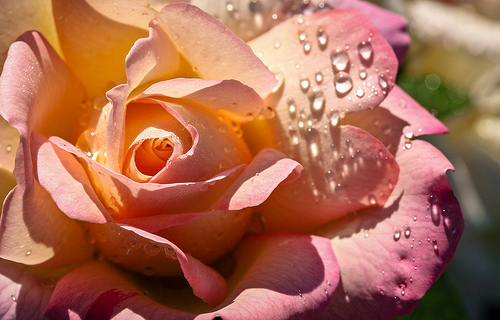

In [7]:
PIL.Image.open(str(roses[1]))

## Create a dictionary with file paths for all kinds of flowers and also a dictionary for labels

In [8]:
flowers_images_dict = {
  'roses' : list(data_dir.glob('roses/*')) ,
  'daisy' : list(data_dir.glob('daisy/*')) , 
  'dandelion' : list(data_dir.glob('dandelion/*')) , 
  'sunflowers' : list(data_dir.glob('sunflowers/*')) , 
  'tulips' : list(data_dir.glob('tulips/*'))  
}

In [9]:
flowers_labels_dict = {
  'roses' : 0 ,
  'daisy' : 1 , 
  'dandelion' : 2 , 
  'sunflowers' : 3 , 
  'tulips' : 4
}

## Use opencv to read path

In [10]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))
img.shape

(240, 320, 3)

### Resize image

In [11]:
cv2.resize(img , (180 ,180)).shape

(180, 180, 3)

### Prepare X and y i.e dependent and independent features

In [12]:
X , y = [] , []
for flower_name , images in flowers_images_dict.items() :
  # print(flower_name)
  # print(len(images))
  
  for image in images :
    img = cv2.imread(str(image))
    # reshape images to 180 * 180
    resized_img = cv2.resize(img , (180 ,180))
    X.append(resized_img)
    y.append(flowers_labels_dict[flower_name])

### Convert image values , target variable to array

In [13]:
X = np.array(X)
y = np.array(y)

### Split images into test and train

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(X , y , random_state = 0)

In [15]:
len(X_train)

2752

In [16]:
len(X_test)

918

### Scale X_train and X_test to range between 0 , 1

In [17]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

### Create CNN Model

In [18]:
num_classes = 5

model = Sequential([
  # 16 filters size 3*3
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  # 32 filters size 3*3
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  # 64 filters size 3*3
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  
  # 128 layers output
  layers.Dense(128, activation='relu'),
  
  # 5 neurons output therefore activation softmax as multiclass classification 
  layers.Dense(num_classes , activation = 'softmax')
])

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
              
model.fit(X_train_scaled, y_train, epochs=30)    

Epoch 1/30


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


86/86 [==============================] - 5s 23ms/step - loss: 1.5441 - accuracy: 0.3725
Epoch 2/30
86/86 [==============================] - 2s 23ms/step - loss: 1.0868 - accuracy: 0.5512
Epoch 3/30
86/86 [==============================] - 2s 23ms/step - loss: 0.8971 - accuracy: 0.6642
Epoch 4/30
86/86 [==============================] - 2s 23ms/step - loss: 0.6692 - accuracy: 0.7496
Epoch 5/30
86/86 [==============================] - 2s 23ms/step - loss: 0.4467 - accuracy: 0.8430
Epoch 6/30
86/86 [==============================] - 2s 23ms/step - loss: 0.2437 - accuracy: 0.9161
Epoch 7/30
86/86 [==============================] - 2s 23ms/step - loss: 0.1416 - accuracy: 0.9600
Epoch 8/30
86/86 [==============================] - 2s 23ms/step - loss: 0.0846 - accuracy: 0.9786
Epoch 9/30
86/86 [==============================] - 2s 23ms/step - loss: 0.0490 - accuracy: 0.9902
Epoch 10/30
86/86 [==============================] - 2s 23ms/step - loss: 0.0316 - accuracy: 0.9949
Epoch 11/30
86/86 [=

In [19]:
model.evaluate(X_test_scaled,y_test)

29/29 [==============================] - 1s 16ms/step - loss: 2.5812 - accuracy: 0.6242


[2.5812158584594727, 0.6241829991340637]

**Here we see that while train accuracy is very high (99%), the test accuracy is significantly low (64.42%) indicating overfitting. Let's make some predictions before we use data augmentation to address overfitting**

In [20]:
from sklearn.metrics import confusion_matrix , classification_report
import numpy as np
y_pred = model.predict(X_test_scaled)
y_pred_classes = [np.argmax(element) for element in y_pred]

print("Classification Report: \n", classification_report(y_test, y_pred_classes))

29/29 [==============================] - 0s 7ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.47      0.57      0.51       176
           1       0.51      0.65      0.57       154
           2       0.75      0.35      0.48       226
           3       0.58      0.75      0.65       150
           4       0.56      0.56      0.56       212

    accuracy                           0.56       918
   macro avg       0.58      0.58      0.56       918
weighted avg       0.59      0.56      0.55       918



In [21]:
X_train.shape

(2752, 180, 180, 3)

In [22]:
X_train.shape[1:]

(180, 180, 3)

## Improve Test Accuracy Using Data Augmentation

In [24]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=X_train.shape[1:]),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [25]:
num_classes = 5

model = Sequential([
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation = 'softmax')
])

model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
              
model.fit(X_train_scaled, y_train, epochs=30)  

Epoch 1/30
86/86 [==============================] - 4s 40ms/step - loss: 1.3511 - accuracy: 0.4302
Epoch 2/30
86/86 [==============================] - 3s 38ms/step - loss: 1.0554 - accuracy: 0.5763
Epoch 3/30
86/86 [==============================] - 3s 39ms/step - loss: 0.9441 - accuracy: 0.6235
Epoch 4/30
86/86 [==============================] - 4s 49ms/step - loss: 0.8608 - accuracy: 0.6628
Epoch 5/30
86/86 [==============================] - 3s 39ms/step - loss: 0.8236 - accuracy: 0.6719
Epoch 6/30
86/86 [==============================] - 3s 38ms/step - loss: 0.7790 - accuracy: 0.7042
Epoch 7/30
86/86 [==============================] - 3s 38ms/step - loss: 0.7314 - accuracy: 0.7144
Epoch 8/30
86/86 [==============================] - 4s 41ms/step - loss: 0.6890 - accuracy: 0.7336
Epoch 9/30
86/86 [==============================] - 3s 38ms/step - loss: 0.6675 - accuracy: 0.7380
Epoch 10/30
86/86 [==============================] - 3s 39ms/step - loss: 0.6375 - accuracy: 0.7587
Epoch 11/

In [26]:
model.evaluate(X_test_scaled,y_test)

29/29 [==============================] - 0s 13ms/step - loss: 1.0594 - accuracy: 0.7157


[1.0594253540039062, 0.7156862616539001]

In [28]:
from sklearn.metrics import confusion_matrix , classification_report
import numpy as np
y_pred = model.predict(X_test_scaled)
y_pred_classes = [np.argmax(element) for element in y_pred]

print("Classification Report: \n", classification_report(y_test, y_pred_classes))

29/29 [==============================] - 0s 12ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.66      0.62      0.64       176
           1       0.77      0.77      0.77       154
           2       0.86      0.73      0.79       226
           3       0.61      0.93      0.74       150
           4       0.69      0.59      0.64       212

    accuracy                           0.72       918
   macro avg       0.72      0.73      0.72       918
weighted avg       0.73      0.72      0.71       918



Classification Report for overfit model: 
             
               precision    recall  f1-score   support

           0       0.51      0.46      0.48       176
           1       0.49      0.64      0.55       154
           2       0.80      0.37      0.51       226
           3       0.55      0.83      0.66       150
           4       0.55      0.58      0.56       212

    accuracy                           0.56       918
   
    macro avg       0.58      0.58      0.55       918

    weighted avg       0.59      0.56      0.55       918


Classification Report for model with augmented image:

          precision    recall  f1-score   support

           0       0.66      0.62      0.64       176
           1       0.77      0.77      0.77       154
           2       0.86      0.73      0.79       226
           3       0.61      0.93      0.74       150
           4       0.69      0.59      0.64       212

    accuracy                           0.72       918
   
    macro avg       0.72      0.73      0.72       918

    weighted avg       0.73      0.72      0.71       918